# Continuation to Pytorch studies

In [1]:
# Imports
import torch
from pathlib import Path
import requests
import pickle
import gzip
import matplotlib.pyplot as plt
import numpy as np

## What is ```torch.nn```

PyTorch provides the elegantly designed modules and classes torch.nn , torch.optim , Dataset , and DataLoader to help you create and train neural networks. In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they’re doing. 

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

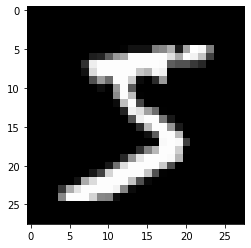

In [4]:
plt.imshow(x_train[0].reshape(28,28), cmap="gray")

In [5]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape

In [6]:
# Layer size
l_size = 784

# Output size
o_size = 10

weights = torch.randn(l_size, o_size) / np.sqrt(l_size)
weights.requires_grad_()
bias = torch.zeros(o_size)
bias.requires_grad_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(torch.matmul(xb, weights) + bias)

In [8]:
batch_size = 64

xb = x_train[0:batch_size]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.2573, -2.2865, -1.9381, -2.8032, -2.2473, -2.5310, -2.2618, -2.2792,
        -2.5151, -2.1498], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

In [10]:
loss_func = nll

In [11]:
yb = y_train[0:batch_size]

In [12]:
print(loss_func(preds, yb))

tensor(2.4144, grad_fn=<NegBackward>)


In [13]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [14]:
print(accuracy(preds, yb))

tensor(0.0781)


In [15]:
from IPython.core.debugger import set_trace

l_rate = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1) // batch_size + 1):
        
        start_i = i * batch_size
        end_i = start_i + batch_size
        
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        # Forward
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        # Backward
        loss.backward()
        
        # Weight update
        with torch.no_grad():
            weights -= weights.grad * l_rate
            bias -= bias.grad * l_rate
            weights.grad.zero_()
            bias.grad.zero_()

In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0793, grad_fn=<NegBackward>) tensor(1.)


***
When using pytorch's ```torch.nn``` module, we are basically skipping most of the steps above that are used when building a neural network. We can see bellow some 'Closing thoughts' that pytorch tutorials provides:

# Closing thoughts

We now have a general data pipeline and training loop which you can use for training many types of models using Pytorch. To see how simple training a model can now be, take a look at the mnist_sample sample notebook.

Of course, there are many things you’ll want to add, such as data augmentation, hyperparameter tuning, monitoring training, transfer learning, and so forth. These features are available in the fastai library, which has been developed using the same design approach shown in this tutorial, providing a natural next step for practitioners looking to take their models further.

We promised at the start of this tutorial we’d explain through example each of torch.nn, torch.optim, Dataset, and DataLoader. So let’s summarize what we’ve seen:

 - __torch.nn__
    - Module: creates a callable which behaves like a function, but can also contain state(such as neural net layer weights). It knows what Parameter (s) it contains and can zero all their gradients, loop through them for weight updates, etc.
    - Parameter: a wrapper for a tensor that tells a Module that it has weights that need updating during backprop. Only tensors with the requires_grad attribute set are updated
    - functional: a module(usually imported into the F namespace by convention) which contains activation functions, loss functions, etc, as well as non-stateful versions of layers such as convolutional and linear layers.
 - __torch.optim__: Contains optimizers such as SGD, which update the weights of Parameter during the backward step
 - __Dataset__: An abstract interface of objects with a ```__len__``` and a ```__getitem__```, including classes provided with Pytorch such as TensorDataset
 - __DataLoader__: Takes any Dataset and creates an iterator which returns batches of data.

# Tensorboard: Data and training visualization

In [17]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [18]:
# Transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Download and import datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

In [19]:
# Data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = True, num_workers = 2)

In [20]:
# Classes names
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [21]:
def my_imshow(img, one_channel = False):
    if one_channel:
        img = img.mean(dim = 0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap = "Greys")
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))

In [22]:
class NeuralNet(nn.Module):
    
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, X):
        
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = X.view(-1, 16 * 4 * 4)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return X
    
NN = NeuralNet()

In [23]:
optimizer = optim.Adam(NN.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

## 1. Tensorboard setup

In [24]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

## 2. Writing to Tensorboard

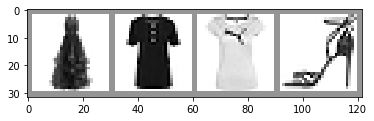

In [25]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

my_imshow(img_grid, one_channel = True)

writer.add_image('four_fashion_mnist_images', img_grid)

In [26]:
%load_ext tensorboard
%reload_ext tensorboard

In [27]:
# Runs tensorboard
import os
runs_base_dir = "./runs"
os.makedirs(runs_base_dir, exist_ok=True)
%tensorboard --logdir {runs_base_dir}

Reusing TensorBoard on port 6006 (pid 15848), started 0:00:42 ago. (Use '!kill 15848' to kill it.)

## 3. Inspect the model using Tensorboard

One of TensorBoard’s strengths is its ability to visualize complex model structures. Let’s visualize the model we built

In [28]:
writer.add_graph(NN, images)
writer.close()

In [29]:
runs_base_dir = "./runs"
os.makedirs(runs_base_dir, exist_ok=True)
%tensorboard --logdir {runs_base_dir}

Reusing TensorBoard on port 6006 (pid 15848), started 0:00:42 ago. (Use '!kill 15848' to kill it.)

# 4. Adding a “Projector” to TensorBoard

We can visualize the lower dimensional representation of higher dimensional data via the add_embedding method

In [30]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [31]:
runs_base_dir = "./runs"
os.makedirs(runs_base_dir, exist_ok=True)
%tensorboard --logdir {runs_base_dir}

Reusing TensorBoard on port 6006 (pid 15848), started 0:00:43 ago. (Use '!kill 15848' to kill it.)

## 5. Tracking model training with tensorboard

In [32]:
def images_to_probs(network, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = network(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [36]:
def plot_classes_preds(network, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(network, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        my_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [37]:
running_loss = 0.
for epoch in range(2):
    
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = NN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 1000 == 999:
            
            # Log of running loss
            writer.add_scalar('training loss', running_loss / 1000, epoch * len(trainloader) + i)
            
            # Log figure of training loss
            writer.add_figure('predictions vs. actuals', plot_classes_preds(NN, inputs, labels),
                             global_step = epoch * len(trainloader) + i)
            
            running_loss = 0.

print('Finished Training')

Finished Training


In [38]:
runs_base_dir = "./runs"
os.makedirs(runs_base_dir, exist_ok=True)
%tensorboard --logdir {runs_base_dir}

Reusing TensorBoard on port 6006 (pid 15848), started 0:10:10 ago. (Use '!kill 15848' to kill it.)

## Assesing trained models with Tensorboard

In [39]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = NN(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

In [41]:
runs_base_dir = "./runs"
os.makedirs(runs_base_dir, exist_ok=True)
%tensorboard --logdir {runs_base_dir}

Reusing TensorBoard on port 6006 (pid 15848), started 0:18:09 ago. (Use '!kill 15848' to kill it.)